In [1]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import scipy.io
import warnings      
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,WhiteKernel, ConstantKernel as C
warnings.filterwarnings("ignore")
from load_data import _PyLasaDataSet

In [2]:
DataSet = _PyLasaDataSet()

Using LASA DataSet from /home/oem/Desktop/KernelizedDynamicalSystems/resources/DataSet


In [5]:
class SIMPLe():
    
    def __init__(self):
        
        self.rec_freq=100
        self.weigth_time=20
        self.weight_pos=10000
        self.index=0
        self.DataSet=_PyLasaDataSet()
        
    def load_letter(self, letter='E'):
        path="/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/" + letter + ".mat"
        X_demo= scipy.io.loadmat(path)
        self.X=np.zeros([2,200])
        self.Y=np.zeros([2,200])
        for j in range(0,200):
            self.X[0,j]=(X_demo['demos'][0,0][0][0][0][0][j]-X_demo['demos'][0,0][0][0][0][0][-1])/10
            self.X[1,j]=(X_demo['demos'][0,0][0][0][0][1][j]-X_demo['demos'][0,0][0][0][0][1][-1])/10
        for j in range(0,199):
            self.Y[0,j]=self.X[0,j+1]
            self.Y[1,j]=self.X[1,j+1]
        self.Y[:,-1]=np.copy(self.X[:,-1])    
         
        self.X=np.transpose(self.X)
        self.Y=np.transpose(self.Y)
        self.traj=np.copy(self.X)
        
    def load(self, shape='GShape'):
        self.shape=shape
        angle_data = getattr(self.DataSet, shape)
        demos = angle_data.demos 
        next_point=1
        X_tot=(demos[0].pos[:,100::1])
        Y_tot=np.zeros((2,np.size(X_tot,1)))
        
        for j in range(np.size(X_tot,1)-next_point): 
            Y_tot[:,j]=X_tot[:,j+next_point]
            
        
        X_tot=np.transpose(X_tot)
        Y_tot=np.transpose(Y_tot)
        
        downsample=10
        
        
        self.X=np.vstack([X_tot[::downsample,:],X_tot[-1,:]])
        self.Y=np.vstack([Y_tot[::downsample,:],Y_tot[-1,:]])
        self.traj=(X_tot[0::downsample,:])
            
    def plot_traj(self):
        plt.scatter(self.traj[0,:],self.traj[1,:], color=[1,0,0])
        plt.show()
        
    def train(self):

        k = C(constant_value=np.sqrt(0.1))  * Matern(2*np.ones(2),[1, self.weight_pos], nu=1.2) + WhiteKernel(0.01, [0.001,1])
        if self.index is not(None):
            self.k_time=Matern(self.rec_freq*self.weigth_time, nu=1.5)
        else:
            self.k_time=C(constant_value=1)
        self.gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=10)
        self.gp.fit((self.X),(self.Y))
        gp_kernels_ = self.gp.kernel_
        kernel_params_ = [gp_kernels_.get_params()['k1__k2__length_scale'], gp_kernels_.get_params()['k1']]
        print(kernel_params_[0])
        self.noise_var_ = self.gp.alpha + gp_kernels_.get_params()['k2__noise_level']
        K_ = gp_kernels_(self.X, self.X)*self.k_time(np.arange(self.X.shape[0]).reshape(-1,1), np.arange(self.X.shape[0]).reshape(-1,1)) + (self.noise_var_ * np.eye(len(self.X)))
        self.K_inv = np.linalg.inv(K_) 
        
        
    def predict(self):
        if self.index is not(None):     
            k_star = self.gp.kernel_(self.cart_pos, self.X)*self.k_time(self.index, np.arange(self.X.shape[0]).reshape(-1,1))
        else:
            k_star = self.gp.kernel_(self.cart_pos, self.X)
        k_star_K_inv_ = np.matmul((k_star), self.K_inv)
        attractor=np.matmul(k_star_K_inv_, self.Y)
        var=np.subtract(self.gp.kernel_(self.cart_pos,self.cart_pos)+self.noise_var_, np.matmul(k_star_K_inv_, np.transpose(k_star)))
        #[attractor, var]= self.gp.predict(self.cart_pos, return_std=True)
        index_belief=np.argmax(k_star)+1
        
        return attractor, var, index_belief
    
    def rollout(self, ind, x, steps):
        
        if ind is not(None):
            self.index=ind
        else:
            self.index=None
        self.cart_pos=np.array([x[0],x[1]]).reshape(1,-1)
        self.traj_rollout=np.zeros((steps,2))
        self.traj_rollout[0,:]=x
        
        for i in range(steps-1):
            [attractor_pos, var, index_belief]=self.predict()
            #self.index=ind
            if  ind is None:
                self.index=None
            else:
                self.index=index_belief  
                
            self.cart_pos=attractor_pos
            self.traj_rollout[i+1,:]= self.cart_pos[0]
            
    def plot_stream(self, index=None):
        self.index=index
        x=np.linspace(np.min(self.traj[:,0])-0.2, np.max(self.traj[:,0])+0.2, 100)
        y=np.linspace(np.min(self.traj[:,1])-0.2, np.max(self.traj[:,1])+0.2, 100)
        u=np.ones((len(x),len(y)))
        v=np.ones((len(x),len(y)))
        BETA=np.ones((len(x),len(y)))
        XX, YY = np.meshgrid(x, y)
        for i in range(len(y)):
            for j in range(len(x)):
                self.cart_pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)  
                [attractor, var, index_belief]= self.predict()
                u[i,j]=np.clip(attractor[0][0]-self.cart_pos[0][0],-20,20)
                v[i,j]=np.clip(attractor[0][1]-self.cart_pos[0][1],-20,20)
        plt.scatter(self.traj[:,0],self.traj[:,1], color=[1,0,0])
        plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
        if self.index is not(None):
            plt.scatter(self.traj[index,0],self.traj[index,1], marker="*", color=[0,1,0], linewidths=2)
        plt.savefig(os.getcwd() + "/figures/"+"figure.png" , dpi=300)
        plt.show()       
SIMPLe=SIMPLe()

[10.          9.53292257]


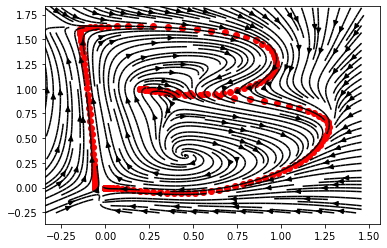

In [6]:
SIMPLe.load_letter(letter='B')
SIMPLe.weight_pos=10
SIMPLe.index=None
SIMPLe.train()
SIMPLe.plot_stream(index=None)
# SIMPLe=SIMPLe()
#SIMPLe.load_letter(letter='B')
ind=None
SIMPLe.rollout(ind, SIMPLe.traj[0,:], 200)


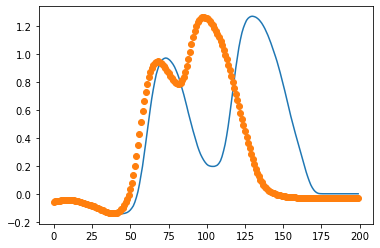

<function matplotlib.pyplot.show(*args, **kw)>

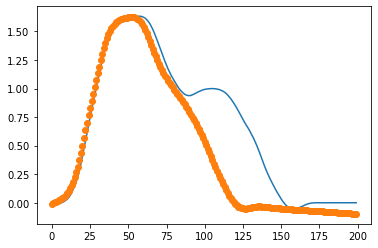

In [55]:
plt.plot(SIMPLe.traj[:,0])
plt.plot(SIMPLe.traj_rollout[:,0], 'o')
plt.show()

plt.plot(SIMPLe.traj[:,1])
plt.plot(SIMPLe.traj_rollout[:,1], 'o')
plt.show

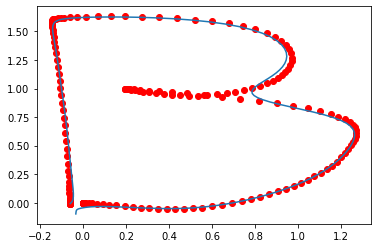

In [56]:
plt.plot(SIMPLe.traj[:,0],SIMPLe.traj[:,1],'o', color=[1,0,0])
plt.plot(SIMPLe.traj_rollout[:,0],SIMPLe.traj_rollout[:,1])
plt.show()

[10.          9.53381501]


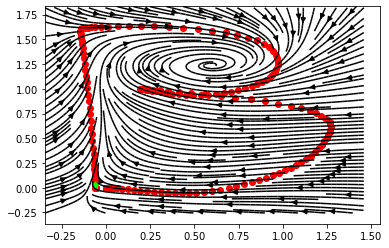

In [61]:
SIMPLe.load_letter(letter='B')
SIMPLe.weight_pos=10
SIMPLe.weigth_time=10
SIMPLe.index=0
SIMPLe.train()
SIMPLe.plot_stream(index=10)
# SIMPLe=SIMPLe()
#SIMPLe.load_letter(letter='B')
ind=0


In [62]:
SIMPLe.rollout(ind, SIMPLe.traj[0,:], 200)

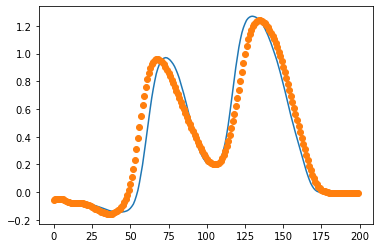

<function matplotlib.pyplot.show(*args, **kw)>

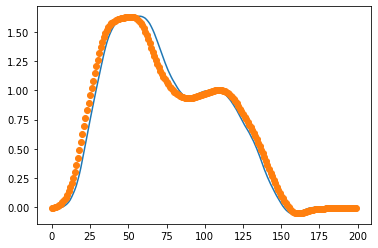

In [63]:
plt.plot(SIMPLe.traj[:,0])
plt.plot(SIMPLe.traj_rollout[:,0], 'o')
plt.show()

plt.plot(SIMPLe.traj[:,1])
plt.plot(SIMPLe.traj_rollout[:,1], 'o')
plt.show

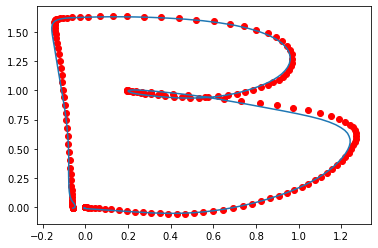

In [64]:
plt.plot(SIMPLe.traj[:,0],SIMPLe.traj[:,1],'o', color=[1,0,0])
plt.plot(SIMPLe.traj_rollout[:,0],SIMPLe.traj_rollout[:,1])
plt.show()

[10.          9.53680804]


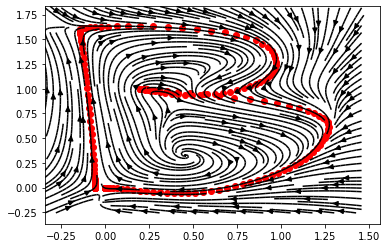

In [5]:
SIMPLe.load_letter(letter='B')
SIMPLe.weight_pos=10
SIMPLe.index=None
SIMPLe.train()
SIMPLe.plot_stream(index=None)

[10.          9.53606038]


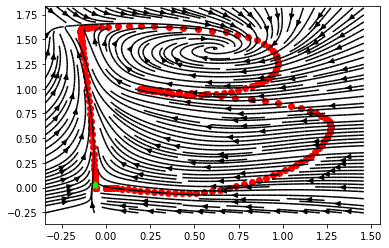

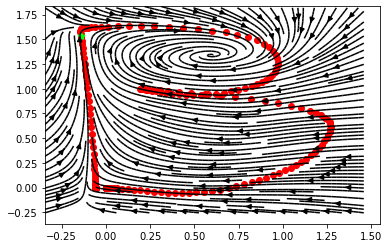

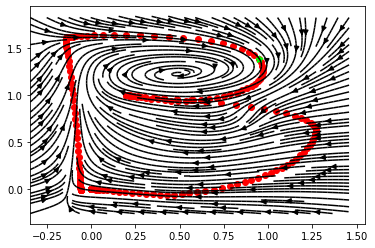

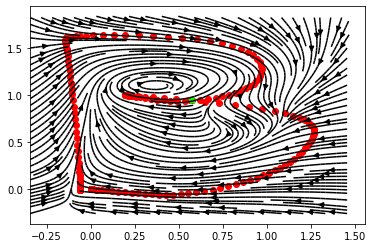

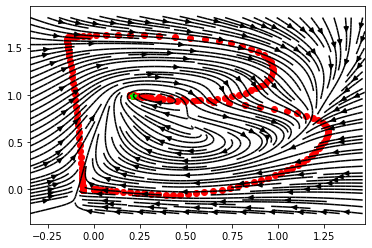

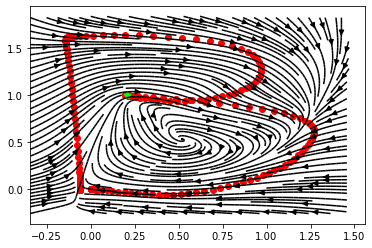

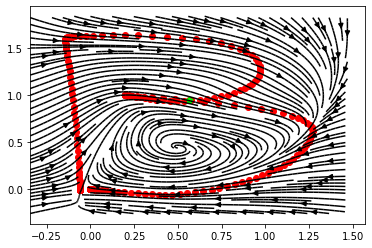

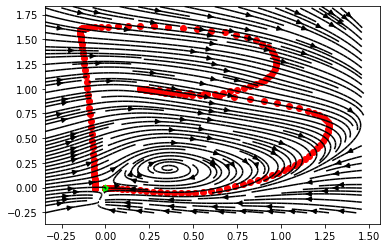

In [68]:
SIMPLe.load_letter('B')
SIMPLe.index=True
SIMPLe.weight_pos=10
SIMPLe.weigth_time=20
SIMPLe.train()
SIMPLe.plot_stream(10)
SIMPLe.plot_stream(40)
SIMPLe.plot_stream(70)
SIMPLe.plot_stream(88)
SIMPLe.plot_stream(100)
SIMPLe.plot_stream(107)
SIMPLe.plot_stream(115)
SIMPLe.plot_stream(199)


[2259.54201423 3670.35274497]


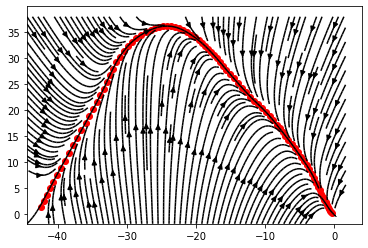

In [74]:
SIMPLe.load(shape='Angle')
SIMPLe.index=None
SIMPLe.weight_pos=10000
SIMPLe.weigth_time=10
SIMPLe.train()
SIMPLe.plot_stream(index=None)

[3802.62374687 3455.24923091]


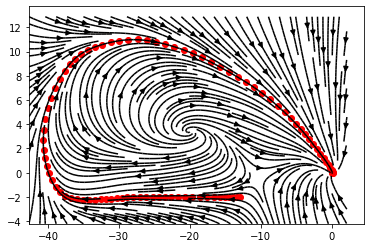

In [75]:
SIMPLe.load(shape='BendedLine')
SIMPLe.train()
SIMPLe.plot_stream(index=None)

[5429.16889133 4414.71021936]


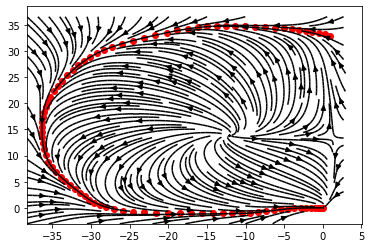

In [76]:
SIMPLe.load(shape='CShape')
SIMPLe.train()
SIMPLe.plot_stream()

[4002.95207069 2976.25663943]


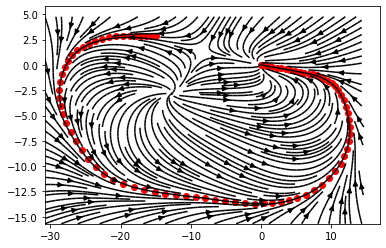

In [77]:
SIMPLe.load(shape='DoubleBendedLine')
SIMPLe.train()
SIMPLe.plot_stream()

[3737.00119174 5977.23871765]


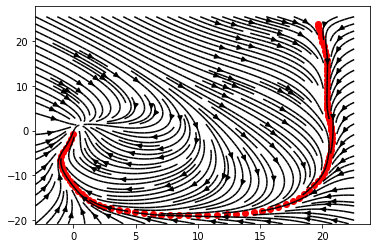

In [78]:
SIMPLe.load(shape='JShape')
SIMPLe.train()
SIMPLe.plot_stream()

[3243.82328611 5178.45384997]


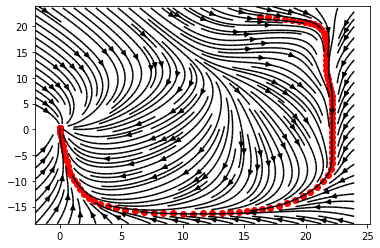

In [79]:
SIMPLe.load(shape='JShape_2')
SIMPLe.train()
SIMPLe.plot_stream()

[4477.28478234 4422.76035113]


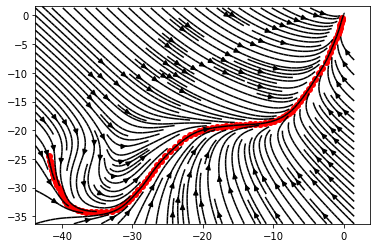

In [95]:
SIMPLe.load(shape='Khamesh')
SIMPLe.train()
SIMPLe.plot_stream()

[2784.42455983 5404.65842184]


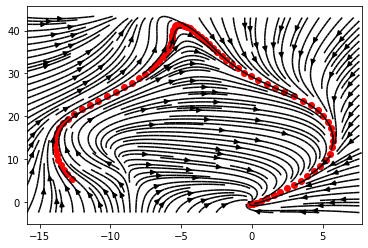

In [82]:
SIMPLe.load(shape='Leaf_1')
SIMPLe.train()
SIMPLe.plot_stream()

[6704.00876947 4840.10780007]


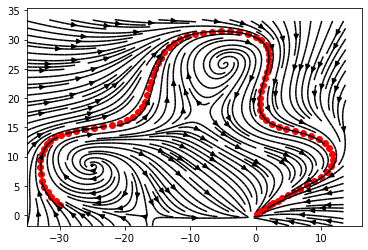

In [83]:
SIMPLe.load(shape='Leaf_2')
SIMPLe.train()
SIMPLe.plot_stream()

[5261.05040673 5579.24233696]


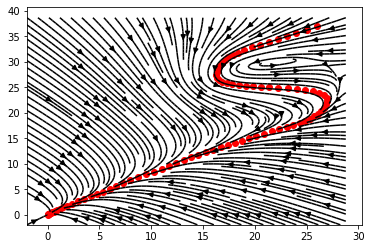

In [84]:
SIMPLe.load(shape='Saeghe')
SIMPLe.train()
SIMPLe.plot_stream()

[4365.5671823 2964.2720704]


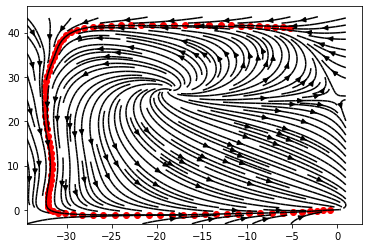

In [85]:
SIMPLe.load(shape='Sharpc')
SIMPLe.train()
SIMPLe.plot_stream()

[4135.24635737 6006.11636237]


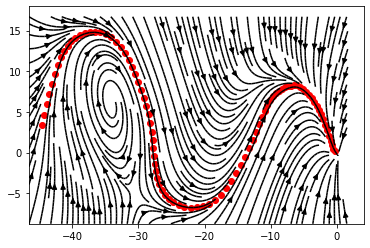

In [86]:
SIMPLe.load(shape='Sine')
SIMPLe.train()
SIMPLe.plot_stream()

[4734.75247026 4517.9139294 ]


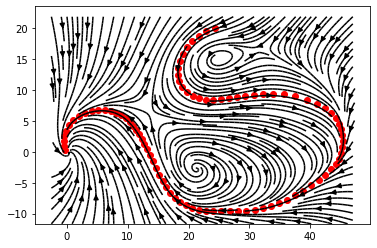

In [87]:
SIMPLe.load(shape='Snake')
SIMPLe.train()
SIMPLe.plot_stream()

[4910.64981962 4074.91789641]


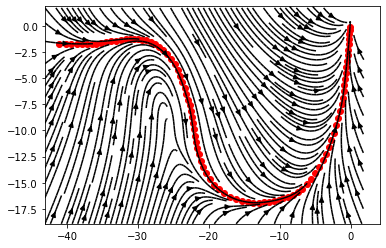

In [88]:
SIMPLe.load(shape='Spoon')
SIMPLe.train()
SIMPLe.plot_stream()

[5913.72263889 4285.72234587]


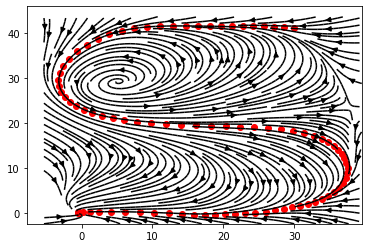

In [89]:
SIMPLe.load(shape='Sshape')
SIMPLe.train()
SIMPLe.plot_stream()

[2204.05770892 2142.74205534]


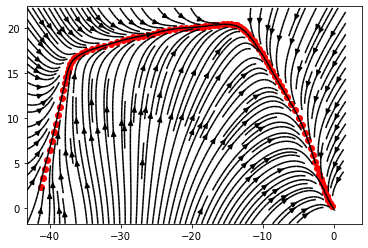

In [90]:
SIMPLe.load(shape='Trapezoid')
SIMPLe.train()
SIMPLe.plot_stream()

[3983.4471827 3489.374544 ]


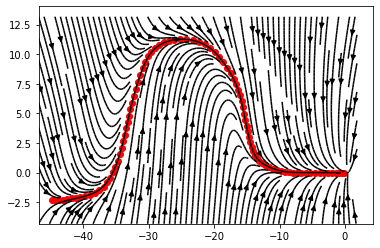

In [91]:
SIMPLe.load(shape='Worm')
SIMPLe.train()
SIMPLe.plot_stream()

[3956.07293538 5222.17306499]


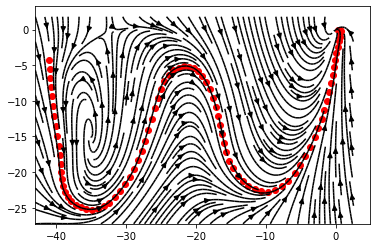

In [92]:
SIMPLe.load(shape='WShape')
SIMPLe.train()
SIMPLe.plot_stream()

[4776.08993931 4486.23728237]


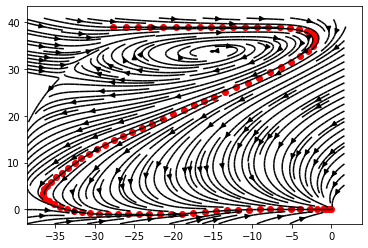

In [96]:
SIMPLe.load(shape='Zshape')
SIMPLe.train()
SIMPLe.plot_stream()

[4773.19986314 4638.44372999]


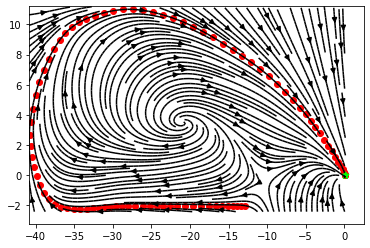

In [25]:
SIMPLe.load(shape='BendedLine')
SIMPLe.weigth_time=20000
SIMPLe.train()
SIMPLe.plot_stream(index=89)

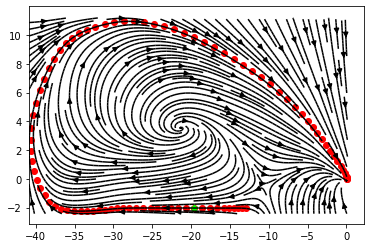

In [27]:
SIMPLe.plot_stream(index=9)

[1542.70468863  940.63969115]


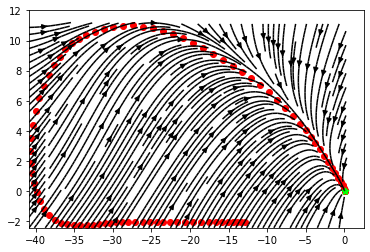

In [23]:
SIMPLe_left=SIMPLe()
SIMPLe_left.load(shape='BendedLine')
SIMPLe_left.weigth_time=20
SIMPLe_left.train()
SIMPLe_left.plot_stream(index=89)

[5886.33985576 3863.32741583]


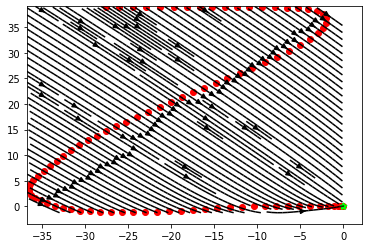

In [24]:
SIMPLe_right=SIMPLe()
SIMPLe_right=SIMPLe()
SIMPLe_right.load(shape='Zshape')
SIMPLe_right.weigth_time=20
SIMPLe_right.train()
SIMPLe_right.plot_stream(index=89)

In [48]:
def rollout_bimanual(ind_right, ind_left, x_right, x_left, steps):

    SIMPLe_left.index=ind_left
    SIMPLe_left.cart_pos=np.array([x_left[0],x_left[1]]).reshape(1,-1)
    SIMPLe_left.traj_rollout=np.zeros((steps,2))
    SIMPLe_left.traj_rollout[0,:]=x_left
    
    SIMPLe_right.index=ind_right
    SIMPLe_right.cart_pos=np.array([x_right[0],x_right[1]]).reshape(1,-1)
    SIMPLe_right.traj_rollout=np.zeros((steps,2))
    SIMPLe_right.traj_rollout[0,:]=x_right

    for i in range(steps-1):
        [attractor_pos_left, var, index_belief_left]=SIMPLe_left.predict()
        [attractor_pos_right, var, index_belief_right]=SIMPLe_right.predict()
        
        
        SIMPLe_left.index=index_belief_right  
        SIMPLe_left.cart_pos=attractor_pos_left
        SIMPLe_left.traj_rollout[i+1,:]= SIMPLe_left.cart_pos[0]
        
        
        SIMPLe_right.index=index_belief_left  
        SIMPLe_right.cart_pos=attractor_pos_right
        SIMPLe_right.traj_rollout[i+1,:]= SIMPLe_right.cart_pos[0]

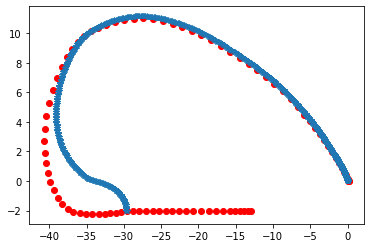

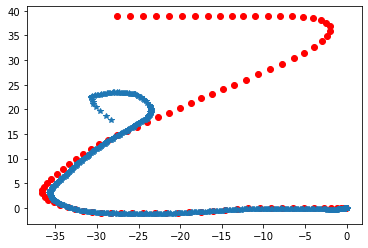

In [64]:
rollout_bimanual(40, 20 , SIMPLe_right.traj[40,:],  SIMPLe_left.traj[20,:], 800)

plt.plot(SIMPLe_left.traj[:,0],SIMPLe_left.traj[:,1],'o', color=[1,0,0])
plt.plot(SIMPLe_left.traj_rollout[:,0],SIMPLe_left.traj_rollout[:,1], '*')
plt.show()
                 
plt.plot(SIMPLe_right.traj[:,0],SIMPLe_right.traj[:,1],'o', color=[1,0,0])
plt.plot(SIMPLe_right.traj_rollout[:,0],SIMPLe_right.traj_rollout[:,1], '*')
plt.show()